# Grasp-and-Lift(GAL) EEG Detection
## Hand movements の分類
- 被験者数: **12**
- 各被験者ごとの試行のデータ系列数: **10**
- 各被験者のひとつのデータ系列内の試行回数: **約30**(試行回数は各系列データごとに異なる) 

training set: 各被験者の最初の8つの試行のデータ系列<br/>
test set: 第9,10番目の試行のデータ系列<br/>

### ラベル
各GALには、6つのイベントを検出するタスク 
(それぞれのイベントにおいて2値分類(ラベル0,1))
　
1. HandStart
1. FirstDigitTouch
1. BothStartLoadPhase
1. LiftOff
1. Replace
1. BothReleased

これらのイベントは常に同じ順序で発生する<br/>
training setには、各件名+シリーズの組み合わせごとに2つのファイル<br/>

### データ
* *_data.csvファイルには、rawの32チャネルEEG(Electroencephalography, 脳波)データ（サンプリングレート500Hz）
* *_events.csvファイルには、すべてのイベントのフレーム・ワイズ・ラベル(1の連続)が含まれる
 * 6つのラベル列は、対応するイベントが±150ms（±75フレーム）以内に発生したかどうかに応じて、ゼロまたは1のいずれか

## 目標
#### 理想: イベントの窓全体を完璧に予測

## 注意
#### 未来データは使用できない(予測する系列の平均などはとれない)

## μ律動
7～12Hzのアーチ状の連続した波で，中心・頭頂部に一側性または両側性に出現する．
開眼時には減衰しないが，手を握るなどの運動や感覚刺激により抑制される

In [1]:
from IPython.display import HTML
HTML(r'<iframe width="560" height="315" src="https://www.youtube.com/embed/y3_Izuop2gY" frameborder="0" allowfullscreen></iframe>')

# パッケージの準備

In [2]:
import numpy as np
import scipy
import scipy.signal as signal
from scipy import fftpack
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

# LeaveOneGroupOut交差検定
from sklearn.model_selection import LeaveOneGroupOut
# AUCスコア
from sklearn.metrics import roc_auc_score

from joblib import Parallel, delayed




# 関数の準備

In [3]:
### データの読み込み ###

def prepare_data_train(fname):
    """ 訓練データの読み込み """
    # EEGデータ読み込み
    data = pd.read_csv(fname)
    # fnameイベントファイルの名前に変換
    events_fname = fname.replace('_data','_events')
    # イベントデータの読み込み
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#id列を削除
    labels=labels.drop(['id' ], axis=1)#id列を削除
    return  clean,labels

def prepare_data_test(fname):
    """ テストデータの読み込み """
    # EEGデータの読み込み
    data = pd.read_csv(fname)
    return data

In [4]:
### 前処理 ###

def preprocess_median_filter(X, kernel):
    """ Median filter"""
    X_m = signal.medfilt(X, kernel_size=kernel)
    return X_m

def preprocess_fir_filter(X, fc):
    """ FIR filter """
    fs = 500
    nyq = fs / 2.0  # ナイキスト周波数

    # フィルタの設計
    # ナイキスト周波数が1になるように正規化
    fe = fc / nyq      # カットオフ周波数1
    numtaps = 15          # フィルタ係数（タップ）の数（要奇数）

    b = scipy.signal.firwin(numtaps, fe) # Low-pass

    # FIRフィルタをかける
    X_FIR = scipy.signal.lfilter(b, 1, X)
    return X_FIR

def cut_off(X, fs):
    """ FFT処理後に高周波を取り除く"""
    # fs: カットオフ周波数[Hz]
    # 時系列のサンプルデータ作成
    n = X.shape[0]                         # データ数
    dt = 0.002                       # サンプリング間隔
    f = 500                           # 周波数

    # FFT 処理と周波数スケールの作成
    X_f = fftpack.fft(X)/(n/2)
    freq = fftpack.fftfreq(n, dt)

    # フィルタ処理
    # ここではカットオフ周波数以上に対応するデータを 0 にしている                          
    X_f2 = np.copy(X_f)
    X_f2[(freq > fs)] = 0
    X_f2[(freq < 0)] = 0

    # 逆 FFT 処理
    # FFT によるフィルタ処理では虚数部が計算されることがあるため
    # real 関数が必要(普段は必要ない)
    X_prep = np.real(fftpack.ifft(X_f2)*n)
    
    return X_prep


def data_preprocess_train(X):
    scaler= StandardScaler()
    X_prep = scaler.fit_transform(X)
#     X_prep = preprocess_fir_filter(X_prep, 100.0)
#     X_prep = cut_off(X, 50.0)

    #ここで他のpreprocessingを追加
    return X_prep

def data_preprocess_test(X):
    scaler= StandardScaler()
    X_prep = scaler.transform(X)
    #ここで他のpreprocessingを追加
    return X_prep

フィルタ処理はどうしたらいいかわからない

In [5]:
# ダウンサンプリングてきななにか
subsample=100

## 各GALごとに, 6 イベント(ラベル列):

1. HandStart
1. FirstDigitTouch
1. BothStartLoadPhase
1. LiftOff
1. Replace
1. BothReleased

In [6]:
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

## 12 の被験者

In [7]:
#被験者数
subjects = range(1,13)
ids_tot = []
pred_tot = []

# データ可視化

## subject1,series1のデータ

In [94]:
fnames = glob('input/train/subj1_series1_data.csv')
print(fnames)
X = []
y = []
for fname in fnames:
    # 訓練データの読み込み
    data,labels = prepare_data_train(fname)
    # すべての系列データ(1-8)
    X.append(data)
    y.append(labels)

# 1次元のlistにする
X = pd.concat(X)
y = pd.concat(y)

['input/train/subj1_series1_data.csv']


In [9]:
y.head()

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [10]:
# μV?
X.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,-31,363,211,121,211,15,717,279,35,158,...,536,348,383,105,607,289,459,173,120,704
1,-29,342,216,123,222,200,595,329,43,166,...,529,327,369,78,613,248,409,141,83,737
2,-172,278,105,93,222,511,471,280,12,177,...,511,319,355,66,606,320,440,141,62,677
3,-272,263,-52,99,208,511,428,261,27,180,...,521,336,356,71,568,339,437,139,58,592
4,-265,213,-67,99,155,380,476,353,32,165,...,550,324,346,76,547,343,446,171,67,581


In [11]:
X.describe()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,...,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,265.934374,404.173194,398.503774,215.615385,144.392189,443.437395,-122.864221,474.953538,88.350681,16.658583,...,450.076714,211.734401,188.356271,162.037800,368.885569,102.616556,305.008302,28.207438,67.214919,155.612497
std,373.911366,313.686274,207.645572,204.065055,141.130921,221.457186,479.160803,198.874064,113.654894,124.604345,...,222.096432,151.240938,189.787461,267.063408,248.232282,212.856072,202.580586,188.116823,256.458072,225.393451
min,-1051.000000,-532.000000,-752.000000,-466.000000,-262.000000,-634.000000,-4095.000000,-893.000000,-300.000000,-517.000000,...,-1283.000000,-378.000000,-427.000000,-1207.000000,-1057.000000,-908.000000,-666.000000,-822.000000,-888.000000,-948.000000
25%,43.000000,218.000000,253.000000,76.000000,37.000000,300.000000,-378.000000,341.000000,24.000000,-59.000000,...,304.000000,111.000000,68.000000,16.000000,213.000000,-41.000000,167.000000,-97.000000,-118.000000,15.000000
50%,210.000000,360.000000,389.000000,210.000000,123.000000,431.000000,-190.000000,469.000000,95.000000,15.000000,...,445.000000,205.000000,161.000000,176.000000,361.000000,85.000000,307.000000,32.000000,45.000000,134.000000
75%,404.000000,515.000000,534.000000,356.000000,242.000000,566.000000,30.000000,606.000000,147.000000,93.000000,...,595.000000,307.000000,266.000000,346.000000,518.000000,232.000000,446.000000,154.000000,246.000000,264.000000
max,3101.000000,3047.000000,1479.000000,1253.000000,801.000000,2417.000000,5111.000000,3203.000000,545.000000,665.000000,...,2088.000000,788.000000,1140.000000,879.000000,1400.000000,1611.000000,1074.000000,859.000000,978.000000,1326.000000


In [12]:
X_columns = X.columns

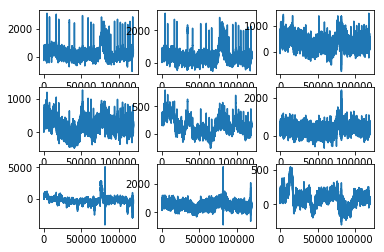

In [13]:
plt.figure(1)

for i in range(0, 9):
    no_fig  = "33" + str(i+1)
    plt.subplot(int(no_fig))
    plt.plot(X[X_columns[i]])

plt.show()

大きい外れ値(第3四分位数以上)がある
#### パルスの原因
- eye blinkとか動いたりとか?
- 突発的ノイズ(ハードウェア依存)?

In [14]:
l = [0.005, 0.05, 0.25, 0.5, 0.75, 0.995]
X.describe(percentiles=l)

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,...,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,265.934374,404.173194,398.503774,215.615385,144.392189,443.437395,-122.864221,474.953538,88.350681,16.658583,...,450.076714,211.734401,188.356271,162.037800,368.885569,102.616556,305.008302,28.207438,67.214919,155.612497
std,373.911366,313.686274,207.645572,204.065055,141.130921,221.457186,479.160803,198.874064,113.654894,124.604345,...,222.096432,151.240938,189.787461,267.063408,248.232282,212.856072,202.580586,188.116823,256.458072,225.393451
min,-1051.000000,-532.000000,-752.000000,-466.000000,-262.000000,-634.000000,-4095.000000,-893.000000,-300.000000,-517.000000,...,-1283.000000,-378.000000,-427.000000,-1207.000000,-1057.000000,-908.000000,-666.000000,-822.000000,-888.000000,-948.000000
0.5%,-385.000000,-162.525000,-89.000000,-263.000000,-166.000000,-89.000000,-1180.000000,-15.000000,-166.000000,-362.525000,...,-155.000000,-160.000000,-189.000000,-869.000000,-406.000000,-399.000000,-234.000000,-453.000000,-505.000000,-389.000000
5%,-183.000000,18.000000,77.000000,-118.000000,-49.000000,111.000000,-682.000000,154.000000,-104.000000,-190.000000,...,100.000000,-31.000000,-58.000000,-249.250000,-8.000000,-220.000000,-29.000000,-286.000000,-324.000000,-166.000000
25%,43.000000,218.000000,253.000000,76.000000,37.000000,300.000000,-378.000000,341.000000,24.000000,-59.000000,...,304.000000,111.000000,68.000000,16.000000,213.000000,-41.000000,167.000000,-97.000000,-118.000000,15.000000
50%,210.000000,360.000000,389.000000,210.000000,123.000000,431.000000,-190.000000,469.000000,95.000000,15.000000,...,445.000000,205.000000,161.000000,176.000000,361.000000,85.000000,307.000000,32.000000,45.000000,134.000000
75%,404.000000,515.000000,534.000000,356.000000,242.000000,566.000000,30.000000,606.000000,147.000000,93.000000,...,595.000000,307.000000,266.000000,346.000000,518.000000,232.000000,446.000000,154.000000,246.000000,264.000000
99.5%,2134.525000,1935.000000,986.000000,741.000000,508.000000,1166.525000,2378.000000,998.525000,465.000000,313.000000,...,1044.000000,593.525000,896.000000,695.000000,1046.000000,730.000000,808.525000,532.525000,734.000000,946.000000


In [15]:
for i in range(len(X_columns)):
    num_under_005 = X.describe(percentiles=l)[X_columns[i]]['0.5%']
    num_over_955 = X.describe(percentiles=l)[X_columns[i]]['99.5%']
    mean_X = X.describe(percentiles=l)[X_columns[i]]['mean']
    X[X_columns[i]] = X[X_columns[i]].where(X[X_columns[i]] > num_under_005, mean_X)
    X[X_columns[i]] = X[X_columns[i]].where(X[X_columns[i]] < num_over_955, mean_X)

X.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,-31.0,363.0,211.0,121.0,211.0,15.0,717.0,279.0,35.0,158.0,...,536.0,348.0,383.0,105.0,607.0,289.0,459.0,173.0,120.0,704.0
1,-29.0,342.0,216.0,123.0,222.0,200.0,595.0,329.0,43.0,166.0,...,529.0,327.0,369.0,78.0,613.0,248.0,409.0,141.0,83.0,737.0
2,-172.0,278.0,105.0,93.0,222.0,511.0,471.0,280.0,12.0,177.0,...,511.0,319.0,355.0,66.0,606.0,320.0,440.0,141.0,62.0,677.0
3,-272.0,263.0,-52.0,99.0,208.0,511.0,428.0,261.0,27.0,180.0,...,521.0,336.0,356.0,71.0,568.0,339.0,437.0,139.0,58.0,592.0
4,-265.0,213.0,-67.0,99.0,155.0,380.0,476.0,353.0,32.0,165.0,...,550.0,324.0,346.0,76.0,547.0,343.0,446.0,171.0,67.0,581.0


In [16]:
X.describe(percentiles=l)

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,...,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,258.649940,398.194020,397.817279,215.106660,143.947543,442.301202,-129.393204,474.515257,87.736721,17.035019,...,450.533299,211.714463,186.575897,164.714824,369.775315,101.860450,305.235589,28.037229,66.759167,154.506534
std,336.076015,281.666758,197.590759,195.566843,135.714534,208.685519,428.230325,189.120822,108.531444,118.772337,...,209.388895,145.478648,179.311602,252.155965,232.865357,202.548349,193.981339,179.589981,246.997426,211.896416
min,-384.000000,-162.000000,-88.000000,-262.000000,-165.000000,-88.000000,-1176.000000,-14.000000,-165.000000,-362.000000,...,-154.000000,-159.000000,-188.000000,-868.000000,-405.000000,-398.000000,-233.000000,-452.000000,-504.000000,-388.000000
0.5%,-334.000000,-111.000000,-42.000000,-227.000000,-129.000000,-30.525000,-965.000000,30.000000,-152.000000,-311.000000,...,-68.000000,-128.000000,-159.000000,-796.000000,-268.000000,-350.000000,-174.525000,-409.000000,-455.000000,-321.000000
5%,-172.000000,27.000000,85.000000,-110.000000,-45.000000,121.000000,-666.000000,163.000000,-100.000000,-183.000000,...,110.000000,-24.000000,-51.000000,-222.000000,4.000000,-211.000000,-19.000000,-278.000000,-315.000000,-156.000000
25%,47.000000,221.000000,257.000000,79.000000,38.000000,303.000000,-374.000000,344.000000,26.000000,-57.000000,...,307.000000,113.000000,70.000000,19.000000,216.000000,-38.000000,170.000000,-93.000000,-114.000000,18.000000
50%,213.000000,363.000000,392.000000,212.000000,125.000000,433.000000,-187.000000,471.000000,94.000000,16.000000,...,448.000000,207.000000,163.000000,173.000000,363.000000,88.000000,305.008302,30.000000,49.000000,137.000000
75%,399.000000,511.000000,530.000000,352.000000,239.000000,562.000000,23.000000,603.000000,146.000000,91.000000,...,591.000000,305.000000,263.000000,342.000000,515.000000,228.000000,443.000000,151.000000,241.000000,260.000000
99.5%,1656.000000,1503.000000,913.000000,681.000000,475.000000,1106.000000,1933.525000,944.000000,448.000000,295.000000,...,984.000000,568.000000,848.000000,654.000000,979.000000,669.000000,762.000000,471.000000,677.000000,872.000000


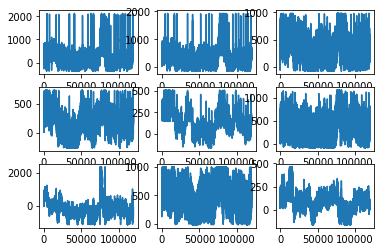

In [17]:
plt.figure(1)

for i in range(0, 9):
    no_fig  = "33" + str(i+1)
    plt.subplot(int(no_fig))
    plt.plot(X[X_columns[i]])

plt.show()

In [95]:
#numpy arrayにする   
X = np.asarray(X.astype(float))
y = np.asarray(y.astype(float))
y.shape

(119496, 6)

In [61]:
# 119,496サンプリングポイント/500Hz ≒ 240s
# 32 channels
X.shape 

(119496, 32)

## Oz channel(subject1,series1)のデータ
### 視覚野あたり
- 実験では，オブジェクトのライトが点灯して動作をスタートさせる

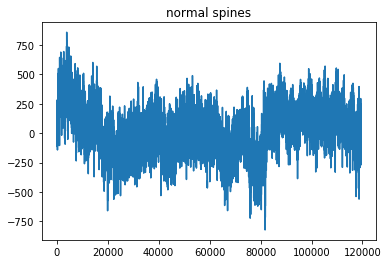

In [96]:
fig, ax = plt.subplots()

X_Oz = X[:, 29]
ax.plot(X_Oz)
ax.set_title('normal spines')

plt.show()

## 平滑化
eye blinkっぽいのを除去

### Median Filter

In [21]:
kernel = 15
X_Oz_m = signal.medfilt(X_Oz, kernel_size=kernel)

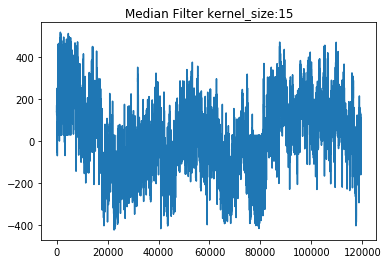

In [22]:
fig, ax = plt.subplots()

ax.plot(X_Oz_m)
ax.set_title('Median Filter kernel_size:'+str(kernel))

plt.show()

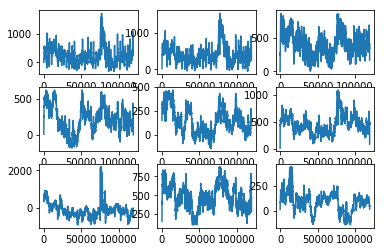

In [23]:
plt.figure(1)
kernel = 125
for i in range(0, 9):   
    X_i = signal.medfilt(X[:, i], kernel_size=kernel)
    no_fig  = "33" + str(i+1)
    plt.subplot(int(no_fig))
    plt.plot(X_i)

plt.show()

### FIR filter

In [24]:
# X_Oz_FIR = scipy.signal.lfilter(b, 1, X_Oz)
X_Oz_FIR = preprocess_fir_filter(X_Oz, 1.0)

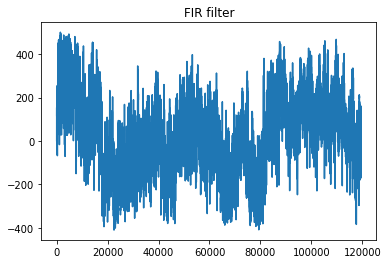

In [25]:
fig, ax = plt.subplots()

ax.plot(X_Oz_FIR)
ax.set_title('FIR filter')

plt.show()

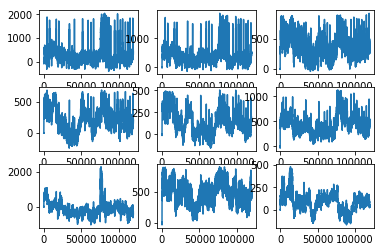

In [26]:
plt.figure(1)

for i in range(0, 9):
    fs = 500
    nyq = fs / 2.0  # ナイキスト周波数

    # フィルタの設計
    # ナイキスト周波数が1になるように正規化
    fe = 20.0 / nyq      # カットオフ周波数1
    numtaps = 125        # フィルタ係数（タップ）の数（要奇数）

    b = scipy.signal.firwin(numtaps, fe) # Low-pass

    # FIRフィルタをかける
    X_FIR = scipy.signal.lfilter(b, 1, X[:,i])
    no_fig  = "33" + str(i+1)
    plt.subplot(int(no_fig))
    plt.plot(X_FIR)

plt.show()

### FFT処理による波形整形

In [27]:
X_Oz.shape

(119496,)

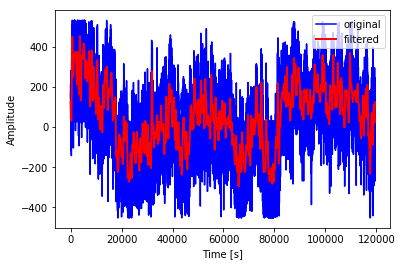

In [28]:
X_Oz_2 = cut_off(X_Oz, 1)

# プロット
# plt.figure(1)
# plt.subplot(211)
# plt.plot(np.abs(X_Oz_f))
# plt.ylabel("Amplitude")
# plt.axis("tight")
# plt.subplot(212)
# plt.plot(np.abs(X_Oz_f2))
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Amplitude")
# plt.axis("tight")

plt.figure(2)
plt.plot(X_Oz, "b", label="original")
plt.plot(X_Oz_2, "r", linewidth=2, label="filtered")
plt.axis("tight")
plt.legend(loc="upper right")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

In [85]:
X_Oz.reshape([1,-1]).shape

(1, 119496)

In [102]:
X_Oz_m_10000 = X_Oz[:10000] - np.mean(X_Oz[:10000])

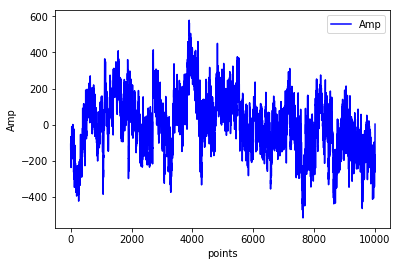

In [103]:
plt.figure()
plt.plot(X_Oz_m_10000, "b", label="Amp")
plt.axis("tight")
plt.legend(loc="upper right")
plt.xlabel("points")
# plt.xlim([0,10000])
plt.ylabel("Amp")

(5000,)

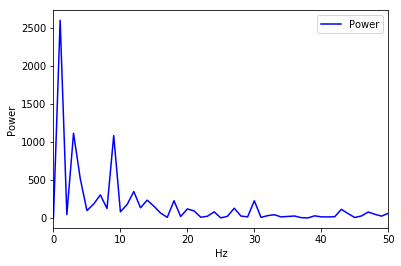

In [116]:
X_Oz_f = spectrum(X_Oz_m_10000) # 20秒
plt.figure()
plt.plot(X_Oz_f, "b", label="Power")
plt.axis("tight")
plt.legend(loc="upper right")
plt.xlabel("Hz")
plt.xlim([0, 50])
plt.ylabel("Power")
X_Oz_f.shape

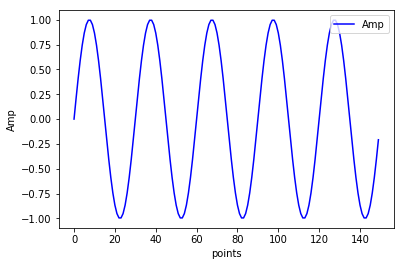

In [125]:
Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)
plt.figure()
plt.plot(y, "b", label="Amp")
plt.axis("tight")
plt.legend(loc="upper right")
plt.xlabel("points")
# plt.xlim([0,10000])
plt.ylabel("Amp")

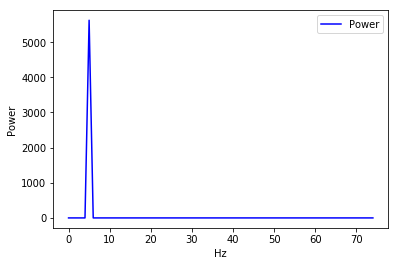

In [120]:
Y = spectrum(y)
plt.figure()
plt.plot(Y, "b", label="Power")
plt.axis("tight")
plt.legend(loc="upper right")
plt.xlabel("Hz")
# plt.xlim([0, 50])
plt.ylabel("Power")

In [118]:
from scipy import stats
from scipy.interpolate import interp1d
import itertools
import numpy as np

def spectrum (vector):
    ''' raw EEG dataベクトルのpower spectrum '''
    A = np.fft.fft(vector)# /len(vector)
    ps = np.abs(A)**2
    # 正のpower spectrum
    ps = ps[:len(ps)//2]
    return ps

def binned (pspectra, n):
    ''' power spectraの配列をnベクトルに圧縮 '''
    l = len(pspectra)
    array = np.zeros([l,n])
    for i,ps in enumerate(pspectra):
        # psの配列の要素数+1
        x = np.arange(1,len(ps)+1)
        # 1D補間法
        f = interp1d(x,ps)#/np.sum(ps))
        array[i] = f(np.arange(1, n+1))
    index = np.argwhere(array[:,0]==-1)
    # n ベクトル
    array = np.delete(array,index,0)
    return array

def feature_vector (readings, bins=60):
    '''
    Create 60, log10-spaced bins for each power spectrum.
    '''
    bins = binned(list(map(spectrum, readings)), bins)
    return np.log10(np.mean(bins, 0))

def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

def vectors (df):
    "raw_values"
    return [feature_vector(group) for group in list(grouper(3, df.raw_values.tolist()))[:-1]]

In [ ]:
# FFT 処理と周波数スケールの作成
X_f = fftpack.fft(X)/(n/2)
freq = fftpack.fftfreq(n, dt)

# フィルタ処理
# ここではカットオフ周波数以上に対応するデータを 0 にしている                          
X_f2 = np.copy(X_f)
X_f2[(freq > fs)] = 0
X_f2[(freq < 0)] = 0

# 逆 FFT 処理
# FFT によるフィルタ処理では虚数部が計算されることがあるため
# real 関数が必要(普段は必要ない)
X_prep = np.real(fftpack.ifft(X_f2)*n)

## イベント

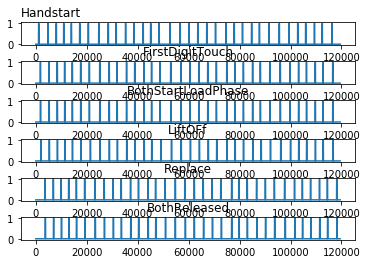

In [29]:
fig, ax0 = plt.subplots(1)

ax0.plot(y[:,0])
ax0.set_title('Handstart', loc='left')

# ax1.plot(y[:,1])
# ax1.set_title('FirstDigitTouch')

# ax2.plot(y[:,2])
# ax2.set_title('BothStartLoadPhase')

# ax3.plot(y[:,3])
# ax3.set_title('LiftOFf')

# ax4.plot(y[:,4])
# ax4.set_title('Replace')

# ax5.plot(y[:,5])
# ax5.set_title('BothReleased')

# plt.subplots_adjust(hspace=0.7)

plt.show()

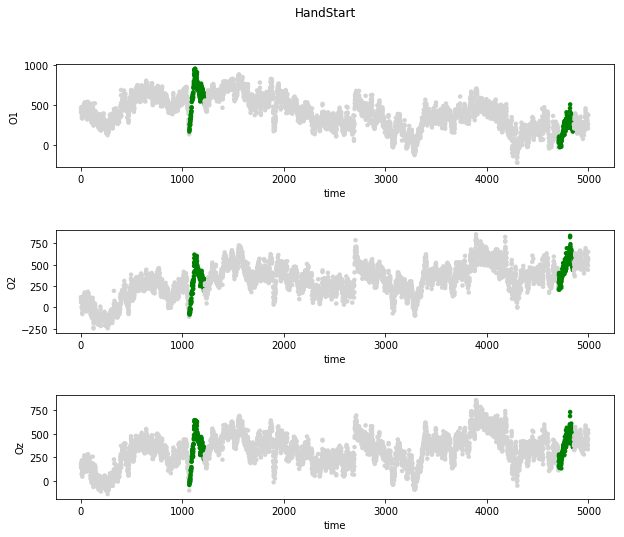

In [8]:
# -*- coding: utf-8 -*-
"""

@author: Stefan Eng
Simple visualization of the "HandStart" event for features "O1", "O2", "C3", "C4"

"""

import pandas as pd
import matplotlib.pyplot as plt

sub1_events_file = 'input/train/subj1_series1_events.csv'
sub1_data_file = 'input/train/subj1_series1_data.csv'

sub1_events = pd.read_csv(sub1_events_file)
sub1_data = pd.read_csv(sub1_data_file)

sub1 = pd.concat([sub1_events, sub1_data], axis = 1)
sub1["time"] = range(0, len(sub1))

sample_sub1 = sub1[sub1["time"] < 5000]

event = "HandStart"
EventColors = ["lightgrey", "green"]

plot_columns = ["O1", "O2", "Oz"]

fig, axes = plt.subplots(nrows=len(plot_columns), ncols=1)
fig.suptitle(event)
for (i, y) in enumerate(plot_columns):
    # Plot all the columns
    sample_sub1.plot(kind="scatter", x="time", y=y, edgecolors='none', ax=axes[i], figsize=(10,8), c=sample_sub1[event].apply(EventColors.__getitem__))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()
# plt.savefig('sub1_hand_start.png')

# 訓練過程 

In [31]:
""" 
各被験者: 訓練->テストデータを予測
8個のtrain系列データと2個のtest系列データ 
"""
for subject in subjects:
    y_raw = []
    raw = []
    ### 訓練データの読み込み #################################
    fnames = glob('input/train/subj%d_series*_data.csv' % (subject))
    for fname in fnames:
        # 訓練データの読み込み
        data,labels = prepare_data_train(fname)
        # すべての系列データ(1-8)
        raw.append(data)
        y_raw.append(labels)

    # 1次元のlistにする
    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #numpy arrayにする
    X_train = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))
    
    
    ### テストデータの読み込み ###############################
    
    fnames = glob('input/test/subj%d_series*_data.csv' % (subject))
    test = []
    idx = []
    for fname in fnames:
        data = prepare_data_test(fname)
        test.append(data)
        idx.append(np.array(data['id']))
    X_test = pd.concat(test)
    ids = np.concatenate(idx)
    ids_tot.append(ids)
    X_test = X_test.drop(['id' ], axis=1)#remove id
    #transform test data in numpy array
    X_test = np.asarray(X_test.astype(float))

    
    ### 学習器 ############################################
    ''' ロジスティック回帰 '''
    lr = LogisticRegression()
    pred = np.empty((X_test.shape[0],6))
    
    ### 前処理 ############################################
    X_train = data_preprocess_train(X_train)
    X_test = data_preprocess_test(X_test)
    
    ### 各イベントごとに学習 ################################
    for i in range(6):
        y_train= y[:,i]
        print('Train subject %d, class %s' % (subject, cols[i]))
        lr.fit(X_train[::subsample,:],y_train[::subsample])
        pred[:,i] = lr.predict_proba(X_test)[:,1]

    pred_tot.append(pred)

Train subject 1, class HandStart
Train subject 1, class FirstDigitTouch
Train subject 1, class BothStartLoadPhase
Train subject 1, class LiftOff
Train subject 1, class Replace
Train subject 1, class BothReleased
Train subject 2, class HandStart
Train subject 2, class FirstDigitTouch
Train subject 2, class BothStartLoadPhase
Train subject 2, class LiftOff
Train subject 2, class Replace
Train subject 2, class BothReleased
Train subject 3, class HandStart
Train subject 3, class FirstDigitTouch
Train subject 3, class BothStartLoadPhase
Train subject 3, class LiftOff
Train subject 3, class Replace
Train subject 3, class BothReleased
Train subject 4, class HandStart
Train subject 4, class FirstDigitTouch
Train subject 4, class BothStartLoadPhase
Train subject 4, class LiftOff
Train subject 4, class Replace
Train subject 4, class BothReleased
Train subject 5, class HandStart
Train subject 5, class FirstDigitTouch
Train subject 5, class BothStartLoadPhase
Train subject 5, class LiftOff
Train s

# テストデータの予測をKaggleのSubmissionの指定形式でファイルに出力

In [32]:
### submissionファイル名
submission_file = 'grasp-sub-simple.csv'

# create pandas object for sbmission
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))

# write file
submission.to_csv(submission_file,index_label='id',float_format='%.3f')

In [37]:
submission

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
subj1_series10_0,0.071174,0.178606,0.169279,0.055199,0.112717,0.076761
subj1_series10_1,0.104276,0.205974,0.188165,0.059010,0.066762,0.052528
subj1_series10_2,0.074372,0.250827,0.250185,0.101659,0.064833,0.045077
subj1_series10_3,0.052973,0.218656,0.213833,0.092887,0.075675,0.050631
subj1_series10_4,0.072778,0.168594,0.151267,0.059522,0.065574,0.056678
subj1_series10_5,0.064630,0.168566,0.152731,0.055496,0.073136,0.057847
subj1_series10_6,0.072003,0.190313,0.169980,0.057961,0.088356,0.058612
subj1_series10_7,0.075187,0.250007,0.243090,0.105966,0.095807,0.078615
subj1_series10_8,0.082292,0.209937,0.198237,0.075506,0.098532,0.078463
subj1_series10_9,0.069958,0.266596,0.259123,0.109575,0.127163,0.074134


# 交差検証法を用いたAUC(Area Under the Curve)による予測能の比較
- AUC: ROC曲線(Receiver Operatorating Characteristic curve、受信者動作特性曲線)の面積
- 混合行列を定量的に比較し，予測能を判断するもの

In [33]:
def fit(X,y):
    # Do here you training
    clf = LogisticRegression()
    clf.fit(X,y)
    return clf

def predict(clf,X):
    # do here your prediction
    preds = clf.predict_proba(X)
    return np.atleast_2d(preds[:,clf.classes_==1])
    
#series used for CV
series = range(1,9)

## Logistic Regression

subject 1
[0.70549427846322299, 0.70407539437437761, 0.68455559571449498, 0.71970923425898081, 0.84366226976323966, 0.7787914616521916]
subject 2
[0.6752135534701087, 0.69186087154105158, 0.55647950525781653, 0.67194585199999035, 0.74915209407979788, 0.74035062864661549]
subject 3
[0.69611411327566775, 0.69189268132673143, 0.6952070092291478, 0.66505066071129348, 0.60627337899712652, 0.61758849141913152]
subject 4
[0.73767686260766685, 0.78727255639027049, 0.76571021532516159, 0.74506347378237636, 0.72650354432282149, 0.70657967922710663]
subject 5
[0.63376427035677463, 0.70202107885046072, 0.71055978112995755, 0.70967574631020558, 0.66149321170236053, 0.68956227431502659]
subject 6
[0.67827405382991279, 0.69146958127511648, 0.72508399009128799, 0.73756231115962601, 0.79904848197397194, 0.77430368157010787]
subject 7
[0.78472206598726535, 0.79340101636924198, 0.7899809229418433, 0.77155710721302184, 0.76946613036165989, 0.74332261945047362]
subject 8
[0.66384337193607479, 0.72842430220

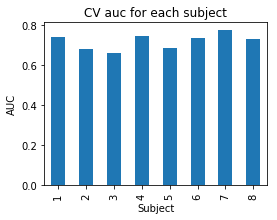

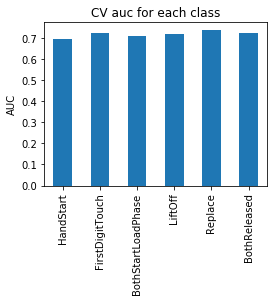

In [36]:
#######number of subjects###############
subjects = range(1,9)
auc_tot = []
pred_tot = []
y_tot = []
###loop on subjects and 8 series for train data + 2 series for test data
for i, subject in enumerate(subjects):
    y_raw= []
    raw = []
    sequence = []
    ################ READ DATA ################################################
    for ser in series:
        fname =  'input/train/subj%d_series%d_data.csv' % (subject,ser)
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
        sequence.extend([ser]*len(data))

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
    X = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))
    sequence = np.asarray(sequence)
#     print(sequence.shape, y.shape, X.shape)


    ################ Train classifiers ########################################
    cv = LeaveOneGroupOut()
    cv.get_n_splits(groups=sequence)
    pred = np.empty((X.shape[0],6))

    for train, test in cv.split(X, y, sequence):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        #apply preprocessing
        X_train = data_preprocess_train(X_train)
        X_test = data_preprocess_test(X_test)
        clfs = Parallel(n_jobs=6)(delayed(fit)(X_train[::subsample,:],y_train[::subsample,i]) for i in range(6))
        preds = Parallel(n_jobs=6)(delayed(predict)(clfs[i],X_test) for i in range(6))
        pred[test,:] = np.concatenate(preds,axis=1)
    pred_tot.append(pred)
    y_tot.append(y)
    # get AUC
    auc = [roc_auc_score(y[:,i],pred[:,i]) for i in range(6)]     
    auc_tot.append(auc)
    print("subject", i + 1)
    print(auc)

pred_tot = np.concatenate(pred_tot)
y_tot = np.concatenate(y_tot)
global_auc = [roc_auc_score(y_tot[:,i],pred_tot[:,i]) for i in range(6)]

print('Global AUC : %.4f' % np.mean(global_auc))

auc_tot = np.asarray(auc_tot)
results = pd.DataFrame(data=auc_tot, columns=cols, index=subjects)
results.to_csv('results_cv_auc.csv')

plt.figure(figsize=(4,3))
results.mean(axis=1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('AUC')
plt.title('CV auc for each subject')
plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')

plt.figure(figsize=(4,3))
results.mean(axis=0).plot(kind='bar')
plt.ylabel('AUC')
plt.title('CV auc for each class')
plt.savefig('cross_val_auc_class.png' ,bbox_inches='tight')

## Kernel SVM

## EXBoost

# やること
## 前処理
- ローバスフィルタ，メディアンフィルタとか->うまくいかない
- ダウンサンプリングとか->うまくいかない
- ブリンクを取って，加算平均とか

## 学習
- 学習器の比較
 - kernel SVM
 - EXBoost
 - DNN

## 可視化
- データ可視化
- 結果可視化